In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import episcanpy.preprocessing as epi_pp
import episcanpy.tools as epi_tl

In [97]:
atac_true = sc.read_h5ad('/workspace/scButterfly/data/lymphoma/lymphoma_ATAC_pp.h5ad')

In [41]:
chr_list = []
for i in list(atac_true.var_names):
    chr = i.split(':')[0][0:3]
    if chr == 'chr': 
        chr_list.append(i)
atac_true = atac_true[:, chr_list]

In [13]:
# Calculate fraction of cells with each peak
peak_cell_counts = np.array((atac_true.X > 0).sum(axis=0)).flatten()
cell_fraction = peak_cell_counts / atac_true.n_obs

# Filter peaks present in at least 0.5% of cells
min_fraction = 0.005
keep_peaks = cell_fraction >= min_fraction
atac_true = atac_true[:, keep_peaks]

In [14]:
atac_true

View of AnnData object with n_obs × n_vars = 14645 × 66372
    obs: 'Cell Types', 'group'
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
atac_true.obs['group'] = atac_true.obs['Cell Types'].map(
    lambda x: 'B' if x in ['B'] else ('LYM' if x in ['Tumor B', 'Tumor B cycling'] else None)
)
data_true = atac_true[atac_true.obs['group'].isin(['B','LYM'])].copy()

sc.pp.log1p(data_true)

sc.tl.rank_genes_groups(
    data_true,
    groupby='group',
    groups=['LYM'],
    reference='B',
    method='wilcoxon',
    pts=True
)

dp_true = sc.get.rank_genes_groups_df(data_true, group='LYM')
dp_true['neg_log10_padj'] = -np.log10(dp_true['pvals_adj'].replace(0, np.nan))

In [16]:
dp_true

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,neg_log10_padj
0,chr9:136653125-136698758,26.566685,6.424584,1.647808e-155,1.093683e-150,0.885929,149.961108
1,chr9:136492663-136559973,25.455959,4.889680,6.064418e-143,2.012538e-138,0.923156,137.696256
2,chr18:79425205-79467412,24.933790,5.583272,3.201452e-137,7.082893e-133,0.900956,132.149789
3,chr9:137062469-137093487,24.597584,5.114100,1.340663e-133,2.224562e-129,0.899249,128.652755
4,chr9:137293050-137322378,24.490416,5.771375,1.868794e-132,2.480712e-128,0.865779,127.605424
...,...,...,...,...,...,...,...
66367,chr6:131062205-131063855,-6.279695,-3.562225,3.392374e-10,2.916185e-09,0.046107,8.535185
66368,chr2:207164057-207167547,-7.710979,-2.943679,1.248561e-14,1.858477e-13,0.106557,12.730843
66369,chr12:8242262-8244275,-8.832314,-3.472183,1.025320e-18,2.381958e-17,0.086749,16.623066
66370,chr8:143015917-143029691,-9.232787,-1.587263,2.636789e-20,7.134486e-19,0.452527,18.146637


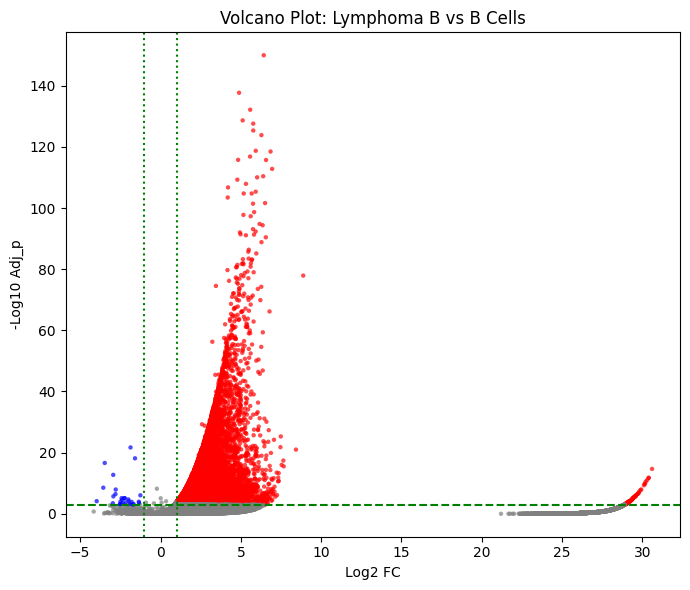

In [17]:
df = dp_true.copy()
df['color'] = 'grey'
df.loc[(df['logfoldchanges'] > 1) & (df['pvals_adj'] < 0.001), 'color'] = 'red'
df.loc[(df['logfoldchanges'] < -1) & (df['pvals_adj'] < 0.001), 'color'] = 'blue'

plt.figure(figsize=(7, 6))
plt.scatter(df['logfoldchanges'], df['neg_log10_padj'], s=10, alpha=0.7, c=df['color'], edgecolor='none')
plt.axhline(-np.log10(0.001), color='green', linestyle='--')
plt.axvline(1, color='green', linestyle='dotted')
plt.axvline(-1, color='green', linestyle='dotted')

# sig_df = df[df['pvals_adj'] < 0.001]
# top_up = sig_df.sort_values(by='logfoldchanges', ascending=False).head(10)
# top_down = sig_df.sort_values(by='logfoldchanges', ascending=True).head(10)

# for _, row in pd.concat([top_up, top_down]).iterrows():
#     plt.text(row['logfoldchanges'], row['neg_log10_padj'],
#              row['names'], fontsize=7, ha='center', va='bottom', color='black')

plt.xlabel('Log2 FC')
plt.ylabel('-Log10 Adj_p')
plt.title('Volcano Plot: Lymphoma B vs B Cells')
plt.tight_layout()
plt.show()

In [52]:
adata = epi_tl.geneactivity(atac_true, gtf_file='/workspace/Benchmarking/data_all/gencode.v48.annotation.gtf', feature_type='gene', key_added='gene_activity')

In [60]:
atac_true

View of AnnData object with n_obs × n_vars = 14645 × 71734
    obs: 'Cell Types'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

In [18]:
atac_true_test = sc.read_h5ad('/workspace/babel/mymodel/truth_atac.h5ad')
atac_pred_test = sc.read_h5ad('/workspace/babel/mymodel/rna_atac_test_preds.h5ad')

In [21]:
atac_true_test.obs['Cell Types'] = atac_true.obs['Cell Types'].reindex(atac_true_test.obs.index)
atac_pred_test.obs['Cell Types'] = atac_true.obs['Cell Types'].reindex(atac_pred_test.obs.index)

In [26]:
atac_true_test.obs['group'] = atac_true_test.obs['Cell Types'].map(
    lambda x: 'B' if x in ['B'] else ('LYM' if x in ['Tumor B', 'Tumor B cycling'] else None)
)
data_true_test = atac_true_test[atac_true_test.obs['group'].isin(['B','LYM'])].copy()

sc.pp.log1p(data_true_test)

sc.tl.rank_genes_groups(
    data_true_test,
    groupby='group',
    groups=['LYM'],
    reference='B',
    method='wilcoxon',
    pts=True
)

dp_true_test = sc.get.rank_genes_groups_df(data_true_test, group='LYM')
dp_true_test['neg_log10_padj'] = -np.log10(dp_true_test['pvals_adj'].replace(0, np.nan))

atac_pred_test.obs['group'] = atac_pred_test.obs['Cell Types'].map(
    lambda x: 'B' if x in ['B'] else ('LYM' if x in ['Tumor B', 'Tumor B cycling'] else None)
)
data_pred_test = atac_pred_test[atac_pred_test.obs['group'].isin(['B','LYM'])].copy()

sc.pp.log1p(data_pred_test)

sc.tl.rank_genes_groups(
    data_pred_test,
    groupby='group',
    groups=['LYM'],
    reference='B',
    method='wilcoxon',
    pts=True
)

dp_pred_test = sc.get.rank_genes_groups_df(data_pred_test, group='LYM')
dp_pred_test['neg_log10_padj'] = -np.log10(dp_pred_test['pvals_adj'].replace(0, np.nan))

In [29]:
dp_true_test

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,neg_log10_padj
0,chr3:155494103-155495873,4.253452,27.870075,0.000021,0.564010,0.316514,0.248713
1,chr7:155109153-155111312,4.191808,27.846638,0.000028,0.564010,0.311927,0.248713
2,chr9:113302448-113303732,4.160985,27.834803,0.000032,0.564010,0.309633,0.248713
3,chr7:11297850-11298864,4.068519,27.798819,0.000047,0.594014,0.302752,0.226204
4,chr3:166612047-166613874,4.030652,4.611942,0.000056,0.594014,0.314220,0.226204
...,...,...,...,...,...,...,...
53392,chr7:122143363-122144673,-1.940913,-2.242578,0.052269,1.000000,0.041284,-0.000000
53393,chr6:157561696-157564089,-2.047469,-1.868299,0.040612,1.000000,0.061927,-0.000000
53394,chr1:59814275-59815469,-2.057156,-3.301243,0.039671,1.000000,0.018349,-0.000000
53395,chr22:33920403-33921444,-2.533578,-4.219745,0.011290,1.000000,0.011468,-0.000000


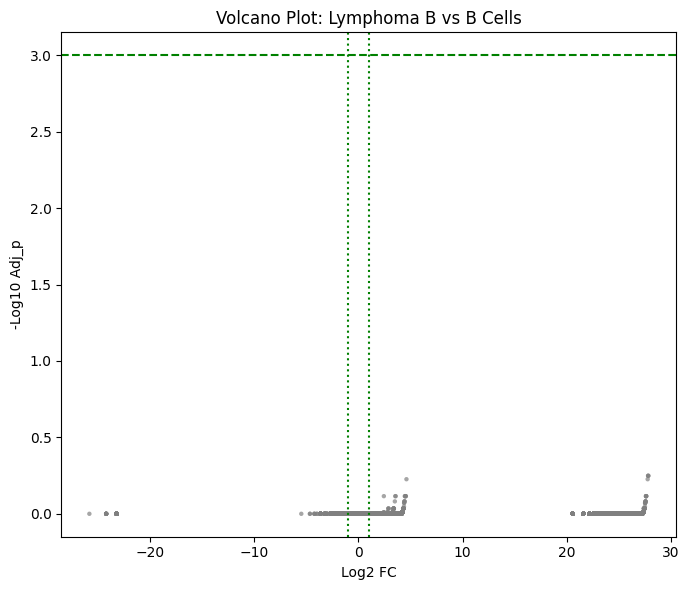

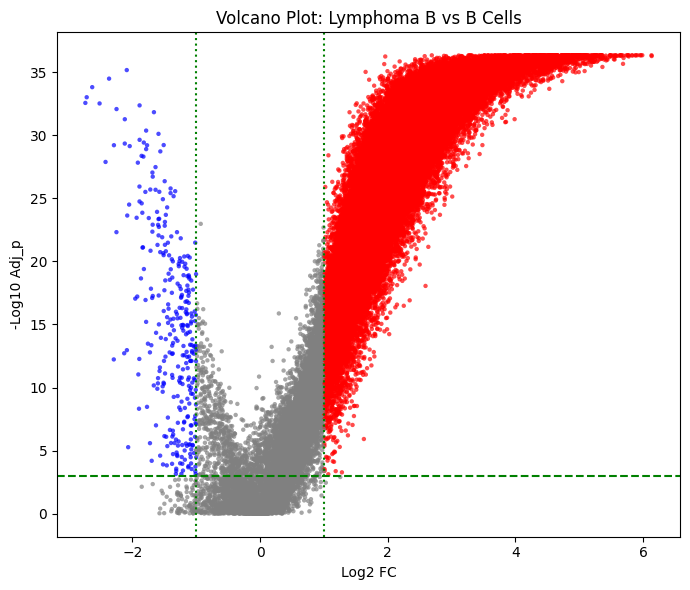

In [ ]:
df = dp_true_test.copy()
df['color'] = 'grey'
df.loc[(df['logfoldchanges'] > 1) & (df['pvals_adj'] < 0.001), 'color'] = 'red'
df.loc[(df['logfoldchanges'] < -1) & (df['pvals_adj'] < 0.001), 'color'] = 'blue'

plt.figure(figsize=(7, 6))
plt.scatter(df['logfoldchanges'], df['neg_log10_padj'], s=10, alpha=0.7, c=df['color'], edgecolor='none')
plt.axhline(-np.log10(0.001), color='green', linestyle='--')
plt.axvline(1, color='green', linestyle='dotted')
plt.axvline(-1, color='green', linestyle='dotted')

# sig_df = df[df['pvals_adj'] < 0.001]
# top_up = sig_df.sort_values(by='logfoldchanges', ascending=False).head(10)
# top_down = sig_df.sort_values(by='logfoldchanges', ascending=True).head(10)

# for _, row in pd.concat([top_up, top_down]).iterrows():
#     plt.text(row['logfoldchanges'], row['neg_log10_padj'],
#              row['names'], fontsize=7, ha='center', va='bottom', color='black')

plt.xlabel('Log2 FC')
plt.ylabel('-Log10 Adj_p')
plt.title('Volcano Plot: Lymphoma B vs B Cells')
plt.tight_layout()
plt.show()

df = dp_pred_test.copy()
df['color'] = 'grey'
df.loc[(df['logfoldchanges'] > 1) & (df['pvals_adj'] < 0.001), 'color'] = 'red'
df.loc[(df['logfoldchanges'] < -1) & (df['pvals_adj'] < 0.001), 'color'] = 'blue'

plt.figure(figsize=(7, 6))
plt.scatter(df['logfoldchanges'], df['neg_log10_padj'], s=10, alpha=0.7, c=df['color'], edgecolor='none')
plt.axhline(-np.log10(0.001), color='green', linestyle='--')
plt.axvline(1, color='green', linestyle='dotted')
plt.axvline(-1, color='green', linestyle='dotted')

# sig_df = df[df['pvals_adj'] < 0.001]
# top_up = sig_df.sort_values(by='logfoldchanges', ascending=False).head(10)
# top_down = sig_df.sort_values(by='logfoldchanges', ascending=True).head(10)

# for _, row in pd.concat([top_up, top_down]).iterrows():
#     plt.text(row['logfoldchanges'], row['neg_log10_padj'],
#              row['names'], fontsize=7, ha='center', va='bottom', color='black')

plt.xlabel('Log2 FC')
plt.ylabel('-Log10 Adj_p')
plt.title('Volcano Plot: Lymphoma B vs B Cells')
plt.tight_layout()
plt.show()

Gene Activity


In [79]:
gene_activity_true = epi_tl.geneactivity(atac_true_test, gtf_file='/workspace/Benchmarking/data_all/gencode.v48.annotation.gtf', feature_type='gene', key_added='gene_activity')
gene_activity_pred = epi_tl.geneactivity(atac_pred_test, gtf_file='/workspace/Benchmarking/data_all/gencode.v48.annotation.gtf', feature_type='gene', key_added='gene_activity')

In [ ]:
gene_activity_true

In [80]:
sc.pp.normalize_total(gene_activity_true)
sc.pp.normalize_total(gene_activity_pred)

In [88]:
correlation_list = []
for i in range(gene_activity_true.shape[0]):
    cell = np.array(gene_activity_true[i,:].X)
    cell_pred = np.array(gene_activity_pred[i,:].X)
    correlation_matrix = np.corrcoef(cell, cell_pred)
    correlation = correlation_matrix[0, 1]
    correlation_list.append(correlation)

In [89]:
sum(correlation_list) / len(correlation_list)

0.295234065386996